# Visualizations and Numerical Values of the Paper

This notebook contains the code required to reproduce all figures and numerical results presented in the paper.  
For selected visualizations, additional numerical values are reported here for reference, as they were omitted from the paper due to page constraints.

In [7]:
# necessary imports
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union

import math
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

from __future__ import annotations
from shapely.geometry import LineString, Point, MultiLineString
from tueplots import axes, bundles, figsizes
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
from tueplots.constants.color import rgb

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# module imports
from src.preprocess_data import preprocess_accident_data
from src.routing_graph import (
    GraphBuildConfig,
    RiskConfig,
    RoutingGraphArtifacts,
    build_routing_graph,
    build_graph_with_risk,
    verify_graph_sanity,
    NodeKey,
)
from src.routing_algorithm import (
    nearest_graph_node,
    route_stats,
    shortest_path_by,
    constrained_min_risk_route,
    run_one_od_routing,
    path_to_multiline_latlon,
)

DATA_DIR = Path("..") / "data" / "panel"

The next cell loads the data frames that were constructed through the merging procedure executed in `01_data_preparation.ipynb`.

In [2]:
accidents_df = pd.read_csv(DATA_DIR / "berlin_bike_accidents.csv")

segments_df = gpd.read_parquet(DATA_DIR / "segments_with_risk.parquet")
junction_df = gpd.read_parquet(DATA_DIR / "junctions_with_risk.parquet")

counting_vs_strafa_df = pd.read_parquet(
    DATA_DIR / "berlin_counting_stations_strava_comparison.parquet"
)

# one geometry per node_id
crossings_gdf = (
    junction_df[["node_id", "geometry"]]
    .dropna(subset=["node_id", "geometry"])
    .drop_duplicates(subset=["node_id"])
    .copy()
)
crossings_gdf = gpd.GeoDataFrame(crossings_gdf, geometry="geometry", crs=junction_df.crs)

print("segments_df:", segments_df.shape)
print("junction_df:", junction_df.shape)
print("crossings_gdf:", crossings_gdf.shape)
print("accidents_df:", accidents_df.shape)
print("counting_vs_strafa_df:", counting_vs_strafa_df.shape)

segments_df: (260100, 215)
junction_df: (171720, 17)
crossings_gdf: (2862, 2)
accidents_df: (23535, 30)
counting_vs_strafa_df: (32868, 4)


In [3]:
plt.rcParams.update(bundles.icml2024(column="half"))
# TUE colors
plt.rcParams.update({"axes.prop_cycle": plt.cycler(color=palettes.tue_plot)})

## Figure 1

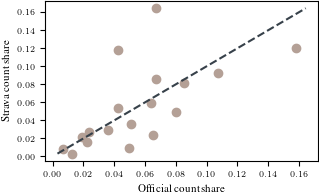

In [4]:
# Year 2023: segment share scatter (official vs Strava)
counting_vs_strafa_df["date"] = pd.to_datetime(counting_vs_strafa_df["date"], errors="coerce")
counting_vs_strafa_df[["total_count", "strata_count"]] = counting_vs_strafa_df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = counting_vs_strafa_df[counting_vs_strafa_df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

yearly = (
    df.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()

# plot
fig, ax = plt.subplots()

ax.scatter(
    yearly["official_share"],
    yearly["strava_share"],
    color=rgb.tue_mauve
)

# 45-degree reference line
minv = min(yearly["official_share"].min(), yearly["strava_share"].min())
maxv = max(yearly["official_share"].max(), yearly["strava_share"].max())
ax.plot(
    [minv, maxv],
    [minv, maxv],
    linestyle="--",
    color=rgb.tue_dark
)

ax.set_xlabel("Official count share")
ax.set_ylabel("Strava count share")

fig.savefig("../report/figs/segment_share.pdf")
plt.show()

## Figure 2

The following cell defines global plotting parameters to ensure consistent visual encoding across all network and routing figures.

In [5]:
# Base network 
BASE_LW = 0.22
BASE_ALPHA = 0.10

# Accidents 
ACC_MS = 4.0
ACC_ALPHA = 0.90

# Junctions 
JUNC_MS = 3.5
JUNC_LW = 0.40
JUNC_ALPHA = 0.25

# High-risk segments 
RISK_LW = 1.9
RISK_ALPHA = 0.95

# Routing
ROUTE_LW = 1.6
ROUTE_ALPHA = 0.95

# OD points
OD_S = 30
OD_ALPHA = 1.0


In [6]:
# Plotting year and month filtering only for panel (a)
PLOT_YEAR, PLOT_MONTH = 2021, 6

CENTER_LAT = 52.518589
CENTER_LON = 13.376665
LAT_TOL = 2.4e-2
LON_TOL = 4.8e-2

METRIC_EPSG = 32633


def viewport_bounds(center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def clip_to_viewport(gdf_ll: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    x0, x1, y0, y1 = viewport_bounds()
    return gdf_ll.cx[x0:x1, y0:y1]


def apply_center_zoom(ax, center_lat=CENTER_LAT, center_lon=CENTER_LON, lat_tol=LAT_TOL, lon_tol=LON_TOL):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)


def _require_crs(gdf: gpd.GeoDataFrame, name: str) -> None:
    if gdf is None or len(gdf) == 0:
        raise ValueError(f"{name} is empty.")
    if gdf.crs is None:
        raise ValueError(f"{name} has no CRS set. Set it upstream (e.g., gdf.set_crs(...)).")


def _to_lonlat(gdf: gpd.GeoDataFrame, name: str) -> gpd.GeoDataFrame:
    _require_crs(gdf, name)
    return gdf.to_crs("EPSG:4326")


# Deduplicate geometries for plotting (avoid alpha stacking)
def dedupe_geometries(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None or len(gdf) == 0:
        return gdf
    return (
        gdf.assign(_wkt=gdf.geometry.to_wkt())
           .drop_duplicates("_wkt")
           .drop(columns="_wkt")
    )


# Panel (a): accidents on network
def plot_panel_a(ax, segments_ll: gpd.GeoDataFrame, accidents_df: pd.DataFrame):
    accidents_gdf = gpd.GeoDataFrame(
        accidents_df,
        geometry=gpd.points_from_xy(accidents_df["XGCSWGS84"], accidents_df["YGCSWGS84"]),
        crs="EPSG:4326",
    )

    # Filter accidents by month for readability
    accidents_m = accidents_gdf.query("year == @PLOT_YEAR and month == @PLOT_MONTH")

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)

    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    accidents_m.plot(
        ax=ax,
        color=rgb.tue_orange,
        markersize=ACC_MS,
        alpha=ACC_ALPHA,
        zorder=3,
    )

    apply_center_zoom(ax)
    ax.axis("off")


# Panel (b): risk + junction context
def plot_panel_b(ax, segments_ll: gpd.GeoDataFrame, junctions_ll: gpd.GeoDataFrame, *, seg_risk_col="risk_weight"):
    if seg_risk_col not in segments_ll.columns:
        raise ValueError(f"Missing segment risk column '{seg_risk_col}' in segments GeoDataFrame")

    x0, x1, y0, y1 = viewport_bounds()

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)
    junctions_plot = dedupe_geometries(junctions_ll)

    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    s = pd.to_numeric(segments_plot[seg_risk_col], errors="coerce")
    q = float(np.nanquantile(s, 0.90))
    high_risk = segments_plot.loc[s >= q]
    high_risk.plot(
        ax=ax,
        color=rgb.tue_red,
        linewidth=RISK_LW,
        alpha=RISK_ALPHA,
        zorder=3,
    )

    j_ctx = junctions_plot.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")

    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")


# Panel (c): routing paths
def plot_panel_c(
    ax,
    *,
    segments_ll: gpd.GeoDataFrame,
    junctions_ll: gpd.GeoDataFrame,
    segments_df: gpd.GeoDataFrame,
    junction_df: gpd.GeoDataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    eps=0.10,
    eta=1.0,
    rng_seed=12345,
    graph_artifacts=None,
):
    x0, x1, y0, y1 = viewport_bounds()

    # Avoid alpha stacking from duplicated geometries
    segments_plot = dedupe_geometries(segments_ll)
    junctions_plot = dedupe_geometries(junctions_ll)

    # OD candidates are chosen from pooled junctions in lon/lat
    rng = np.random.default_rng(rng_seed)
    candidates = junctions_plot.cx[x0:x1, y0:y1].copy()
    if "degree" in candidates.columns:
        candidates = candidates.query("degree >= 3")

    if len(candidates) < 2:
        raise ValueError(
            f"Not enough junction candidates inside the fixed window. Found {len(candidates)}. "
        )

    coords = np.column_stack([candidates.geometry.x.to_numpy(), candidates.geometry.y.to_numpy()])  # lon, lat
    i, j = rng.choice(len(coords), size=2, replace=False)
    origin_lonlat = (float(coords[i, 0]), float(coords[i, 1]))
    dest_lonlat = (float(coords[j, 0]), float(coords[j, 1]))
    ox, oy = origin_lonlat
    dx, dy = dest_lonlat

    # Build graph once
    if graph_artifacts is None:
        graph_artifacts = build_graph_with_risk(
            segments_panel_gdf=segments_df,
            crossings_gdf=crossings_gdf,
            junction_panel_gdf=junction_df,
            risk_cfg=RiskConfig(eta=eta),
        )
    G = graph_artifacts.G

    # Run routing
    result = run_one_od_routing(
        segments_panel_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_df,
        origin_lonlat=origin_lonlat,
        dest_lonlat=dest_lonlat,
        eps=eps,
        eta=eta,
        metric_epsg=METRIC_EPSG,
    )

    if result.get("status") == "disconnected":
        shortest_geom = None
        safe_geom = None
    else:
        shortest_geom = path_to_multiline_latlon(
            G, result["shortest_length_path"], metric_epsg=METRIC_EPSG, choose_by="length_m"
        )
        safe_geom = path_to_multiline_latlon(
            G, result["constrained_min_risk_path"], metric_epsg=METRIC_EPSG, choose_by="risk_total"
        )

    # Base network
    segments_plot.plot(
        ax=ax,
        color=rgb.tue_dark,
        linewidth=BASE_LW,
        alpha=BASE_ALPHA,
        zorder=1,
    )

    # Junction context
    j_ctx = junctions_plot.cx[x0:x1, y0:y1]
    if "degree" in j_ctx.columns:
        j_ctx = j_ctx.query("degree >= 3")
    j_ctx.plot(
        ax=ax,
        markersize=JUNC_MS,
        facecolors="none",
        edgecolors=rgb.tue_dark,
        linewidths=JUNC_LW,
        alpha=JUNC_ALPHA,
        zorder=2,
    )

    # Routes
    if shortest_geom is not None:
        gpd.GeoSeries([shortest_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_blue,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=4,
        )

    if safe_geom is not None:
        gpd.GeoSeries([safe_geom], crs="EPSG:4326").plot(
            ax=ax,
            color=rgb.tue_green,
            linewidth=ROUTE_LW,
            alpha=ROUTE_ALPHA,
            zorder=5,
        )

    # Origin / destination markers
    ax.scatter([ox], [oy], s=16, marker="o", color=rgb.tue_ocre, zorder=7)
    ax.scatter([dx], [dy], s=24, marker="x", color=rgb.tue_ocre, linewidths=1.2, zorder=7)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.axis("off")

    return result, G, shortest_geom, safe_geom, (ox, oy, dx, dy)


def make_three_panel_figure(
    *,
    segments_df: gpd.GeoDataFrame,
    junction_df: gpd.GeoDataFrame,
    accidents_df: pd.DataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3panel.pdf",
):
    # Convert plotting layers to lon/lat for consistent viewport slicing
    segments_ll = _to_lonlat(segments_df, "segments_df")
    junctions_ll = _to_lonlat(junction_df, "junction_df")

    # Clip to viewport to keep PDF size manageable
    segments_ll = clip_to_viewport(segments_ll)
    junctions_ll = clip_to_viewport(junctions_ll)

    # Build pooled graph artifacts once (used in panel c)
    graph_artifacts = build_graph_with_risk(
        segments_panel_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_df,
        risk_cfg=RiskConfig(eta=eta),
    )

    with plt.rc_context(bundles.icml2024(column="full", nrows=1, ncols=3)):
        fig, axs = plt.subplots(1, 3)

        plot_panel_a(axs[0], segments_ll, accidents_df)
        plot_panel_b(axs[1], segments_ll, junctions_ll, seg_risk_col="risk_weight")

        routing_result = plot_panel_c(
            axs[2],
            segments_ll=segments_ll,
            junctions_ll=junctions_ll,
            segments_df=segments_df,
            junction_df=junction_df,
            crossings_gdf=crossings_gdf,
            eps=eps,
            eta=eta,
            graph_artifacts=graph_artifacts,
        )

        labels = ["(a) Data", "(b) Risk estimation", "(c) Safety routing"]
        for ax, lab in zip(axs, labels):
            ax.text(0.5, -0.06, lab, transform=ax.transAxes, ha="center", va="top")

        fig.savefig(outpath)
        return fig, axs, routing_result


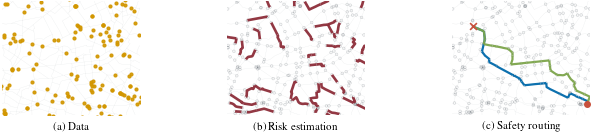

In [7]:
fig, axs, (result_from_fig, G_from_fig, shortest_geom_from_fig, safe_geom_from_fig, od_coords) = make_three_panel_figure(
    segments_df=segments_df,
    junction_df=junction_df,
    accidents_df=accidents_df,
    crossings_gdf=crossings_gdf,
    eps=0.10,
    eta=1.0,
    outpath="../report/figs/map_3_panels.pdf",
)
plt.show()


### Numerical Values (omitted from the paper)

The next cell uses the routing results computed in the previous cell and unpacks the results from the `make_three_panel_figure` function.

In [8]:
result_berlin = result_from_fig
G = G_from_fig
shortest_geom = shortest_geom_from_fig
safe_geom = safe_geom_from_fig
ox, oy, dx, dy = od_coords


The next cell computes the route statistics.

In [9]:
# Check route lengths + detour constraint
p_len = result_berlin["shortest_length_path"]
p_safe = result_berlin["constrained_min_risk_path"]

paths_identical = (p_len == p_safe)
print("Paths identical:", paths_identical)

# Choose-by for MultiGraph edge selection:
st_len  = route_stats(G, p_len,  choose_by="length_m")
st_safe = route_stats(G, p_safe, choose_by="risk_total")

shortest_length = float(st_len["length_m"])
safe_length     = float(st_safe["length_m"])

print(f"Shortest path length: {shortest_length:.1f} m")
print(f"Safe route length:    {safe_length:.1f} m")

# Report route risk 
print(f"Shortest route risk_total: {float(st_len['risk_total_sum']):.3f}")
print(f"Safe route risk_total:     {float(st_safe['risk_total_sum']):.3f}")

# Check detour constraint
eps = result_berlin.get("params", {}).get("eps", result_berlin.get("eps", 0.10))
max_allowed = (1.0 + float(eps)) * shortest_length
detour_pct = ((safe_length / shortest_length) - 1.0) * 100.0 if shortest_length > 0 else float("nan")

print(f"Detour: {detour_pct:.2f}%")
print(f"Max allowed length: {max_allowed:.1f} m")

if safe_length <= max_allowed + 1e-6:
    print("Constraint satisfied.")
else:
    print("WARNING: Constraint violated (check routing selection / edge-choice consistency).")

# Report deltas from result_berlin for cross-check
if "delta_L" in result_berlin and result_berlin["delta_L"] is not None:
    print(f"delta_L: {100*result_berlin['delta_L']:.2f}%")
if "delta_R" in result_berlin and result_berlin["delta_R"] is not None:
    print(f"delta_R: {100*result_berlin['delta_R']:.2f}%")


Paths identical: False
Shortest path length: 7911.0 m
Safe route length:    8463.2 m
Shortest route risk_total: 0.005
Safe route risk_total:     0.003
Detour: 6.98%
Max allowed length: 8702.1 m
Constraint satisfied.
delta_L: 6.98%
delta_R: 39.82%


## Figure 3

In [2]:
# Filter and Aggregate segments dataframe
import geopandas as gpd; import matplotlib.pyplot as plt
segments_with_risk = gpd.read_parquet("../data/panel/segments_with_risk.parquet")
segments_with_risk = segments_with_risk.loc[:, ["counter_name", "year", "month", "geometry", "latitude", "longitude",
                                                "total_accidents", "sum_strava_total_trip_count", "street_name", "rr_eb"]]
original_crs = segments_with_risk.crs
agg_logic = {
    'total_accidents': 'sum',
    'sum_strava_total_trip_count': 'sum',
    'geometry': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'street_name': 'first',
    'rr_eb': 'first'
}
agg_segments = segments_with_risk.groupby('counter_name').agg(agg_logic).reset_index()
agg_segments = gpd.GeoDataFrame(agg_segments, geometry='geometry', crs=original_crs)

In [3]:
# Filter and Aggregate junctions dataframe
junctions_with_risk = gpd.read_parquet(path="../data/panel/junctions_with_risk.parquet")
original_crs = junctions_with_risk.crs
agg_logic = {
    'total_accidents': 'sum',
    'monthly_strava_trips': 'sum',
    'geometry': 'first',
    'rr_eb': 'first'
}
agg_junctions = junctions_with_risk.groupby('node_id').agg(agg_logic).reset_index()
agg_junctions = gpd.GeoDataFrame(agg_junctions, geometry='geometry', crs=original_crs)

In [26]:
# functioin for zooming into the map

def viewport_bounds(center_lat, center_lon, lat_tol, lon_tol):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def apply_center_zoom(ax, center_lat, center_lon, lat_tol, lon_tol):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

[array([0.        , 0.41176471, 0.66666667]), array([0.68627451, 0.70196078, 0.71764706]), array([0.55294118, 0.17647059, 0.22352941])]


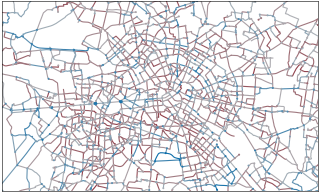

In [59]:
def plot_segment_risk(
    segment_df,
    junction_df,
    risk_column: str = "risk_estimate",
    cmap: str = "berlin",
    output_path: str | None = None,

):
    plt.rcParams.update(figsizes.icml2024_half())
    fig, ax = plt.subplots()
# use TuePlots colors
    plt.rcParams.update(bundles.icml2024())
    
    diverging_colors = [rgb.tue_blue, rgb.pn_gray, rgb.tue_red]
    print(diverging_colors)
    cmap = LinearSegmentedColormap.from_list(
    "tue_blue_red",
    diverging_colors,
    N=256)

    if risk_column not in segment_df.columns:
        raise ValueError(f"Column '{risk_column}' not found.")
    
    risk_segments = segment_df[risk_column]
    risk_junctions = junction_df[risk_column]

    risk_all = np.concatenate([
        risk_segments[risk_segments > 0].to_numpy(),
        risk_junctions[risk_junctions > 0].to_numpy(),
    ])

    # set range for colorbar normalization
    vmin = risk_all.min()
    vmax = risk_all.max()

    norm = LogNorm(vmin=vmin, vmax=vmax)

    segment_df.plot(
        ax=ax,
        column=risk_column,
        cmap=cmap,
        linewidth=0.8,
        legend=False,
        legend_kwds={
            "shrink": 0.6,
            "pad": 0.05,
        },
        norm=norm,
        zorder=1
    )

    junction_df.plot(     
        ax=ax,
        column=risk_column,
        cmap=cmap,
        linewidth=0.8,
        norm=norm,
        markersize=0.4,
        zorder=2 # plot junctions on top
    )

    # Hide axes
    #ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    fig = ax.get_figure()
    cbar_ax = fig.axes[-1]     
    cbar_ax.minorticks_off()

    # zooming into center to improve readability
    apply_center_zoom(ax=ax, center_lat=5820000, center_lon=391000, lat_tol=1.2*6000, lon_tol=2.0*6000)


    for spine in cbar_ax.spines.values():
        spine.set_linewidth(0.4)

    #plt.title("Relative Risk per Segment", pad=0.1)    

    if output_path:
        plt.savefig(output_path, dpi=200)
    plt.show()


plot_segment_risk(
    segment_df=agg_segments,
    junction_df=agg_junctions,
    risk_column="rr_eb",
    cmap="coolwarm",
    output_path="../report/figs/risk_segments.pdf",
)


## Figure 4
### Plot special segments and assigned accidents

Centering around: 5822439.521158219 404456.1715306927


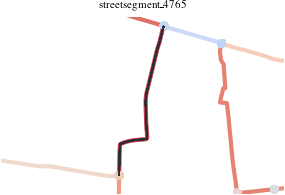

In [43]:
def viewport_bounds(center_lat, center_lon, lat_tol, lon_tol):
    x0, x1 = center_lon - lon_tol, center_lon + lon_tol
    y0, y1 = center_lat - lat_tol, center_lat + lat_tol
    return x0, x1, y0, y1


def apply_center_zoom(ax, center_lat, center_lon, lat_tol, lon_tol):
    x0, x1, y0, y1 = viewport_bounds(center_lat, center_lon, lat_tol, lon_tol)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

def plot_special_segments(
    filepath_segments: str,
    filepath_junctions: str,
    filepath_accidents: str,
    risk_column: str = "risk_estimate",
    cmap: str = "berlin",
    output_path: str | None = None,
    segment_name: str = "segment_1234",
):
    plt.rcParams.update(bundles.icml2024())
    fig, ax = plt.subplots()

    gdf_segments = agg_segments
#    gdf_segments = gdf_segments[gdf_segments["counter_name"]==segment_name]
    gdf_junctions = gpd.read_parquet(filepath_junctions)
    gdf_accidents = gpd.read_parquet(filepath_accidents)
    gdf_accidents = gdf_accidents[gdf_accidents["counter_name"]==segment_name]
    
    gdf_segments.to_crs(epsg=4326)
    segment = gdf_segments[gdf_segments["counter_name"]==segment_name].iloc[0]
    center_lat = segment.geometry.centroid.y
    center_lon = segment.geometry.centroid.x
    print("Centering around: " + str(center_lat), str(center_lon))

    if risk_column not in gdf_segments.columns:
        raise ValueError(f"Column '{risk_column}' not found.")
    
    risk_segments = gdf_segments[risk_column]
    risk_junctions = gdf_junctions[risk_column]

    risk_all = np.concatenate([
        risk_segments[risk_segments > 0].to_numpy(),
        risk_junctions[risk_junctions > 0].to_numpy(),
    ])

    # set range for colorbar normalization
    vmin = risk_all.min()
    vmax = risk_all.max()

    norm = LogNorm(vmin=vmin, vmax=vmax)

    gdf_segments.plot(
        ax=ax,
        column=risk_column,
        cmap=cmap,
        linewidth=3.0,
        legend=False,
        norm=norm,
        zorder=1,
        alpha=0.8,
    )

    gdf_junctions.plot(     
        ax=ax,
        column=risk_column,
        cmap=cmap,
        linewidth=3.0,
        norm=norm,
        markersize=10,
        zorder=2, # plot junctions on top
        alpha=1.0
    )

    gdf_accidents.plot(
        ax=ax,
        color="#302F2F",
        linewidth=1,
        markersize=1,
        zorder=3 # plot accidents on top
    )

    # Hide axes
    ax.set_axis_off()
    fig = ax.get_figure()
    cbar_ax = fig.axes[-1]     
    cbar_ax.minorticks_off()

    apply_center_zoom(ax=ax, center_lat=center_lat, center_lon=center_lon, lat_tol=1.2*500, lon_tol=1.2*800)


    plt.title(segment_name)    

    if output_path:
        plt.savefig(output_path, dpi=100)
    plt.show()


plot_special_segments(
    filepath_segments="../data/panel/segments_with_risk.parquet",
    filepath_junctions="../data/panel/junctions_with_risk.parquet",
    filepath_accidents="../data/panel/berlin_bike_accident_strava_panel.parquet",
    risk_column="rr_eb",
    cmap="coolwarm",
    output_path="../report/figs/streetsegment.pdf",
    segment_name = "streetsegment_4765"
)